## Load metadata

In [25]:
import pandas as pd

metadata_path = '/content/drive/MyDrive/cse151a_groupProject/isic-2024-challenge/train-metadata.csv'
isic_2020_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2020/ISIC2020_Training_labels.csv'
isic_2019_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2019/ISIC2019_Training_labels.csv'
isic_2018_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2018/ISIC2018_Training_labels.csv'
isic_2017_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2017/ISIC2017_Training_labels.csv'
isic_2016_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2016/ISBI2016_Training_labels.csv'

metadata = pd.read_csv(metadata_path)
isic_2020 = pd.read_csv(isic_2020_path)
isic_2019 = pd.read_csv(isic_2019_path)
isic_2018 = pd.read_csv(isic_2018_path)
isic_2017 = pd.read_csv(isic_2017_path)
isic_2016 = pd.read_csv(isic_2016_path)

isic_2020 = isic_2020[['image_name', 'target']]
isic_2020.rename(columns={'image_name': 'isic_id'}, inplace=True)

isic_2019 = isic_2019[['image', 'MEL']]
isic_2019.rename(columns={'image': 'isic_id', 'MEL': 'target'}, inplace=True)

isic_2018 = isic_2018[['image', 'MEL']]
isic_2018.rename(columns={'image': 'isic_id', 'MEL': 'target'}, inplace=True)

isic_2017 = isic_2017[['image_id', 'melanoma']]
isic_2017.rename(columns={'image_id': 'isic_id', 'melanoma': 'target'}, inplace=True)

isic_2016.columns = ['isic_id', 'target']
isic_2016['target'] = isic_2016['target'].map({'malignant': 1, 'benign': 0})

metadata = pd.concat([metadata, isic_2020, isic_2019, isic_2018, isic_2017, isic_2016], ignore_index=True)
metadata = metadata[['isic_id', 'tbp_lv_color_std_mean', 'age_approx', 'target']]

combined_metadata = pd.concat([metadata, isic_2020, isic_2019, isic_2018, isic_2017, isic_2016], ignore_index=True)

combined_metadata['tbp_lv_color_std_mean'].fillna(combined_metadata['tbp_lv_color_std_mean'].mean(), inplace=True)
combined_metadata['age_approx'].fillna(combined_metadata['age_approx'].mean(), inplace=True)


In [26]:
if 'tbp_lv_color_std_mean' in metadata.columns:
    print("Column 'tbp_lv_color_std_mean' found")
else:
    print("Column 'tbp_lv_color_std_mean' not found")

metadata['tbp_lv_color_std_mean'].fillna(metadata['tbp_lv_color_std_mean'].mean(), inplace=True)
metadata['age_approx'].fillna(metadata['age_approx'].mean(), inplace=True)

Column 'tbp_lv_color_std_mean' found


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import warnings
warnings.filterwarnings("ignore")


X = combined_metadata['tbp_lv_color_std_mean'].values.reshape(-1, 1)
y = combined_metadata['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_test_scaled = scaler.transform(X_poly_test)

logreg = LogisticRegression()
logreg.fit(X_poly_train_scaled, y_train)

y_pred = logreg.predict(X_poly_test_scaled)
y_pred_prob = logreg.predict_proba(X_poly_test_scaled)[:, 1]
binary_cross_entropy = log_loss(y_test, y_pred_prob)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

print(f"\nBinary Cross-Entropy Loss: {binary_cross_entropy}")


Binary Cross-Entropy Loss: 0.11270604269968806


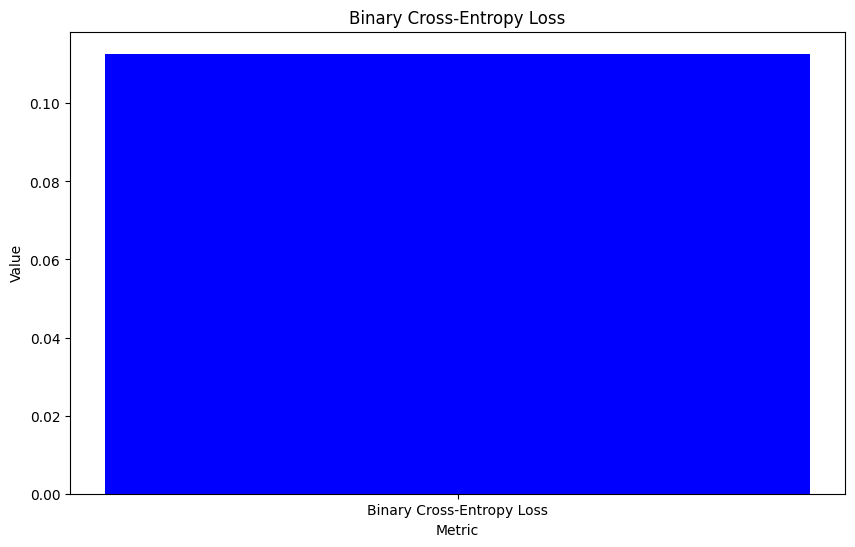

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(['Binary Cross-Entropy Loss'], [binary_cross_entropy], color=['blue'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Binary Cross-Entropy Loss')
plt.show()


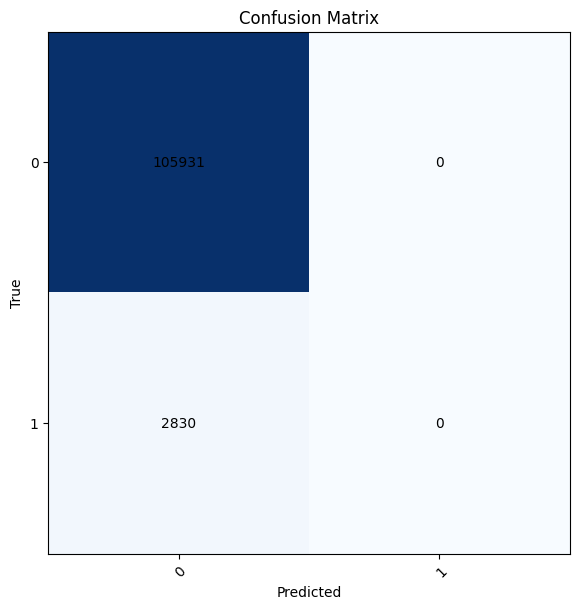

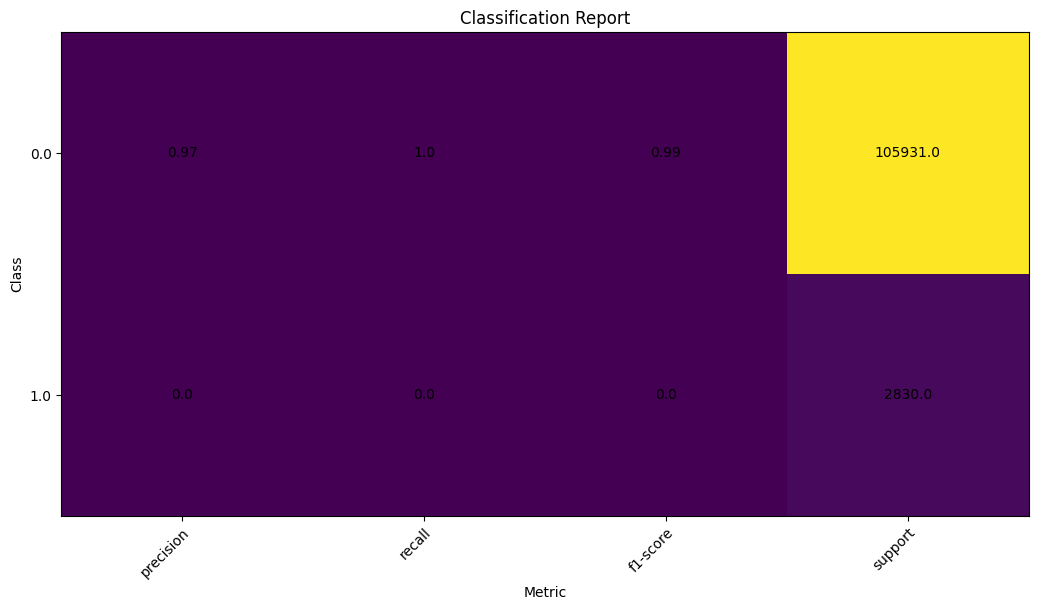

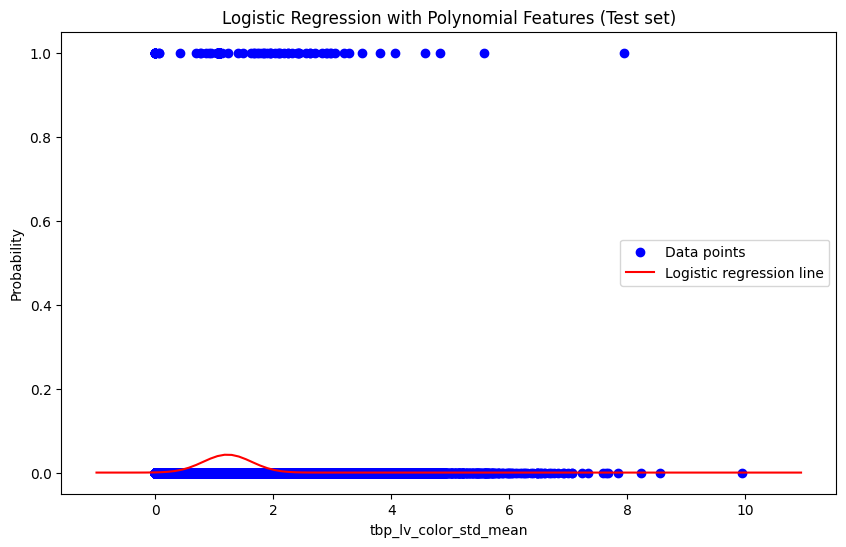

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix, cmap='Blues')

ax.set_xticks(np.arange(len(['0', '1'])))
ax.set_yticks(np.arange(len(['0', '1'])))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(['0', '1'])):
    for j in range(len(['0', '1'])):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

labels = list(class_report.keys())[:-3]
metrics = list(class_report[labels[0]].keys())
values = np.array([[class_report[label][metric] for metric in metrics] for label in labels])

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(values, cmap='viridis')

ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(metrics)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(metrics)):
        text = ax.text(j, i, round(values[i, j], 2),
                       ha="center", va="center", color="black")

ax.set_title("Classification Report")
fig.tight_layout()
plt.xlabel('Metric')
plt.ylabel('Class')
plt.show()

def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xx = np.linspace(x_min, x_max, 100).reshape(-1, 1)
    xx_poly = poly.transform(xx)
    xx_poly_scaled = scaler.transform(xx_poly)
    Z = model.predict_proba(xx_poly_scaled)[:, 1]

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Data points')
    plt.plot(xx, Z, color='red', label='Logistic regression line')
    plt.xlabel('tbp_lv_color_std_mean')
    plt.ylabel('Probability')
    plt.title(title)
    plt.legend()
    plt.show()

plot_decision_boundary(X_test, y_test, logreg, 'Logistic Regression with Polynomial Features (Test set)')


In [30]:
features = ['tbp_lv_color_std_mean', 'age_approx']
target_variable = 'target'

X = combined_metadata[features].values
y = combined_metadata[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

logreg = LogisticRegression()
logreg.fit(X_train_poly, y_train)

y_pred = logreg.predict(X_test_poly)
y_pred_prob = logreg.predict_proba(X_test_poly)[:, 1]
binary_cross_entropy = log_loss(y_test, y_pred_prob)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

print(f"\nBinary Cross-Entropy Loss: {binary_cross_entropy}")


Binary Cross-Entropy Loss: 0.10194112247226822


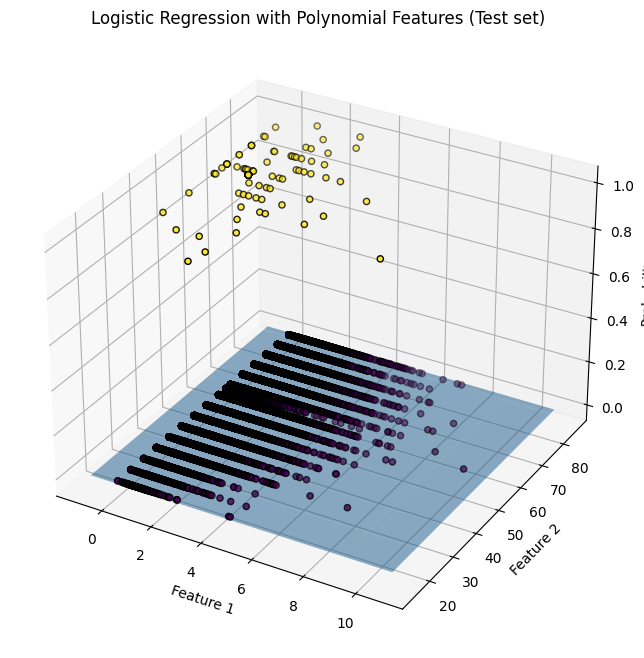

In [24]:
def plot_3d_decision_boundary(X, y, model, scaler, poly, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    grid_poly = poly.transform(grid_scaled)

    Z = model.predict_proba(grid_poly)[:, 1]
    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, alpha=0.5, rstride=100, cstride=100)
    ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap='viridis', edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability')
    plt.show()

plot_3d_decision_boundary(X_test, y_test, logreg, scaler, poly, 'Logistic Regression with Polynomial Features (Test set)')

chatgpt usage:
"do you use multiple features or just one feature for polynomial regression" "how do i implement logistic regression with polynomial features" "how would i make a 3d plot using this code?"
"this is the plot from the polynomial model. interpret it please"\